In [55]:
from __future__ import division
import sys
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd

In [56]:
from concurrent.futures import ProcessPoolExecutor, wait

In [57]:
from __future__ import division, print_function
import numpy as np
from scipy import optimize as sco
import click

In [58]:
data_t0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuTau_1_1_1.npy',mmap_mode='r')
data_m0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuMu_1_1_1.npy',mmap_mode='r')
data_e0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuE_1_1_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_Corsika_11057_11058_10670_trial.npy',mmap_mode='r')

In [59]:
maskl_t = data_t0['logan_veto']['SPE_rlogl']-data_t0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_m = data_m0['logan_veto']['SPE_rlogl']-data_m0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_e = data_e0['logan_veto']['SPE_rlogl']-data_e0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_c = data_c0['logan_veto']['SPE_rlogl']-data_c0['logan_veto']['Cascade_rlogl'] >-0.1
masks_t = (data_t0['preds']['n1'] >= 0.99) & (data_t0['preds']['n4'] >= 0.8)
masks_m = (data_m0['preds']['n1'] >= 0.99) & (data_m0['preds']['n4'] >= 0.8)
masks_e = (data_e0['preds']['n1'] >= 0.99) & (data_e0['preds']['n4'] >= 0.8)
masks_c = (data_c0['preds']['n1'] >= 0.99) & (data_c0['preds']['n4'] >= 0.8)
mask_t = maskl_t & masks_t
mask_m = maskl_m & masks_m
mask_e = maskl_e & masks_e
mask_c = maskl_c & masks_c
data_t = data_t0[mask_t]
data_m = data_m0[mask_m]
data_e = data_e0[mask_e]
data_c = data_c0[mask_c]
print(data_t.shape,data_m.shape,data_e.shape,data_c.shape)

(990,) (51,) (12,) (0,)


990 63


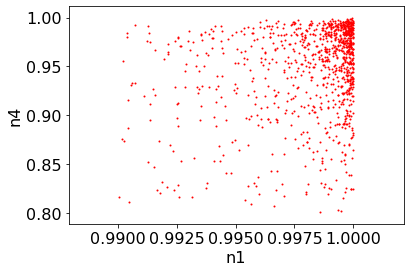

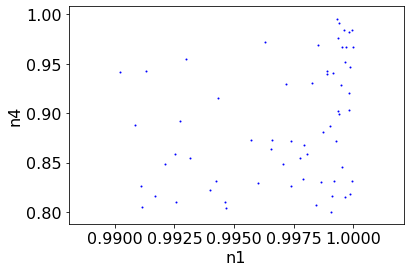

In [60]:
data_t_label = [0]*len(data_t)
array_t = np.array([data_t_label,data_t['preds']['n4'],data_t['preds']['n1'],data_t['weight_val']]).T 
data_m_label = [1]*len(data_m)
array_m = np.array([data_m_label,data_m['preds']['n4'],data_m['preds']['n1'],data_m['weight_val']]).T 
arrs =  array_m
data_e_label = [2]*len(data_e)
array_e = np.array([data_e_label,data_e['preds']['n4'],data_e['preds']['n1'],data_e['weight_val']]).T 
arrs =  np.append(arrs,array_e, axis = 0)
data_c_label = [3]*len(data_c)
array_c = np.array([data_c_label,data_c['preds']['n4'],data_c['preds']['n1'],data_c['weight_val']]).T 
arrs =  np.append(arrs,array_c, axis = 0)
index_values_t = range(len(array_t))
index_values_b = range(len(arrs))
print(len(array_t),len(arrs))
column_values = ['label', 'n4', 'n1','weight'] 
sig_df = pd.DataFrame(data = array_t,  index = index_values_t, columns = column_values) 
bkg_df = pd.DataFrame(data = arrs,  index = index_values_b, columns = column_values)
sig_df.plot(kind='scatter', x='n1', y='n4', s=1, c='r')
bkg_df.plot(kind='scatter', x='n1', y='n4', s=1, c='b')

In [61]:
for i in column_values:
    print(i, np.any([isinstance(val, str) for val in sig_df[i]]))

label False
n4 False
n1 False
weight False


In [62]:
class BinnedPoissonLikelihood():
    '''
    Likelihood: Binned Poisson
    Model: P_B(x) + lmd_S * P_S(x)
    '''
    def __init__(self, sig_hist, bkg_hist, random_state):
        self.sig_hist = sig_hist
        self.bkg_hist = bkg_hist
        self.random_state = check_random_state(random_state)

    def log_likelihood(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        result = np.sum(data_hist * np.log(expected_hist) - expected_hist)
        return -result

    def test_statistic(self, lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = self.bkg_hist
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def test_statistic_best(self, lmd, true_lmd, data_hist):
        expected_hist = (self.bkg_hist + lmd * self.sig_hist)
        null_hist = (self.bkg_hist + true_lmd * self.sig_hist)
        result = np.sum(data_hist * (np.log(expected_hist) -
                        np.log(null_hist)) - expected_hist + null_hist)
        return -result
    
    def fit_lmd(self, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic,
            x0=pars,
            bounds=par_bounds,
            args=(data_hist,),
            approx_grad=True
        )

        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or "FACTR" in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic,
                x0=pars,
                bounds=par_bounds,
                args=(data_hist,),
                approx_grad=True
            )
            i += 1

        return fmin, xmin
    
    def fit_lmd_best(self, true_lmd, data_hist):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic_best,
            x0=pars,
            bounds=par_bounds,
            args=(true_lmd, data_hist,),
            approx_grad=True
        )
        #print("min_dict1",min_dict)
        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic_best,
                x0=pars,
                bounds=par_bounds,
                args=(true_lmd, data_hist,),
                approx_grad=True
            )
            #print("min_dict",min_dict)
            i += 1

        return fmin, xmin

In [63]:
def get_default_binning():
    bins_x = np.linspace(0.99, 1.0, 5)
    bins_y = np.linspace(0.8, 1.0, 3)
    #bins_y = np.array([0.2, 0.8, 1.])
    return bins_x, bins_y
def build_histograms(sig_df, bkg_df, bins_x, bins_y,
                    # livetime=(3600 * 24 * 365 * 7),
                     density=False,
                     weight_col='weight'):
    #axii are reversed in historgamm2d
    sig, xe, ye = np.histogram2d(
        sig_df['n1'],
        sig_df['n4'],
        bins=[bins_x, bins_y],
        #weights=sig_df[weight_col],
        density=density)
   
    bkg, xe, ye = np.histogram2d(
        bkg_df['n1'],
        bkg_df['n4'],
        bins=[bins_x, bins_y],
        #weights=bkg_df[weight_col],
        density=density)
    return sig, bkg, xe, ye

def plot_histogram(H,xedges,yedges):
    fig = plt.figure(figsize=(20, 5),facecolor ='w')
    plt.rcParams.update({'font.size': 16})
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
    ax = fig.add_subplot()
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, H)

In [144]:
#stats.py

def check_random_state(random_state):
    if isinstance(random_state, np.random.RandomState):
        return random_state
    else:
        if not isinstance(random_state, int):
            raise ValueError('random_state has to be either an int or of ' +
                             'type np.random.RandomState!')
        else:
            random_state = np.random.RandomState(random_state)
            return random_state
def sample_from_hist(hist, n_samples, random_state):
    '''Sample `n_samples` from a histogram and return them binned as a
    histogram in the same binning.
    Parameters
    ----------
    hist : ndarray
        Histogram to resample
    n_samples: int
        Number of samples to draw from the histogram
    Returns
    -------
    sampled_hist : ndarray
        Returns a histogram with the same shape of `hist` with `n_samples`
        entries.
    '''
    random_state = check_random_state(random_state)

    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]

    values = random_state.rand(n_samples)
    value_bins = np.searchsorted(cdf, values)

    sampled_hist = np.bincount(value_bins,
                               minlength=np.prod(hist.shape))
    sampled_hist = sampled_hist.reshape(hist.shape)
    return sampled_hist

In [145]:
class SignalInjector(object):
    def __init__(self,
                 sig_dist, bkg_dist,
                 random_state,
                 sig_exp=None, bkg_exp=None):
        if sig_exp is not None:
            self.sig_exp = sig_exp
        else:
            self.sig_exp = np.sum(sig_dist)
        if bkg_exp is not None:
            self.bkg_exp = bkg_exp
        else:
            self.bkg_exp = np.sum(bkg_dist)

        self.sig_dist = sig_dist
        self.bkg_dist = bkg_dist
        self.random_state = check_random_state(random_state)

    def calc_n_events_per_trial(self, n_trials):
        n_sig_per_trial = self.random_state.poisson(lam=self.sig_exp, size=n_trials)
        n_bkg_per_trial = self.random_state.poisson(lam=self.bkg_exp, size=n_trials)
        return n_sig_per_trial, n_bkg_per_trial

    def create_samples(self):
        dists = [self.sig_dist, self.bkg_dist]
        n_samples = [self.n_sig_per_trial,
                     self.n_bkg_per_trial]
        samples_sig, samples_bkg = [], []
        for i, dist in enumerate(dists):
            for j in range(len(n_samples[i])):
                sample = sample_from_hist(dist, n_samples[i][j], self.random_state)
                if i == 0:
                    samples_sig.append(sample)
                elif i == 1:
                    samples_bkg.append(sample)
        self.sig_samples = samples_sig
        self.bkg_samples = samples_bkg
        return samples_sig, samples_bkg
    
    def return_samples(self, n_trials):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)

        self.create_samples()
        return np.array(self.sig_samples) + np.array(self.bkg_samples)

    def do_trials(self, n_trials, llh):
        self.n_sig_per_trial, self.n_bkg_per_trial = \
            self.calc_n_events_per_trial(n_trials)

        self.create_samples()

        ts_vals = []
        lmds = []
        
        true_lmd = self.sig_exp / float(np.sum(self.sig_dist))
        #print(true_lmd)
        for i in range(n_trials):
        #for i in tqdm(range(n_trials)):
            samples = (self.sig_samples[i] + self.bkg_samples[i])

            ts, lmd = llh.fit_lmd_best(true_lmd, samples)
            ts_vals.append(-ts)
            lmds.extend(lmd)
        # print(np.mean(lmds), np.median(lmds))
        return ts_vals, lmds

In [146]:
def scan_neyman_row(sig_inj, n_samples, likelihood, mu):
    sig_ts, _ = sig_inj.do_trials(
        n_samples, likelihood)
    sig_ts = np.array(sig_ts)
    sig_ts[sig_ts < 0] = 0
    #print(sig_ts, mu)
    return sig_ts, mu

def scan_neyman_plane(sig, bkg, bkg_exp,
                      mu_bins, ts_bins, n_samples_per_mu,
                      n_jobs=1, save=False, out_path=None):
    def save_stuff(out_path, hist, mu):
        if out_path is not None:
            out_path = os.path.join(
                out_path, 'ts_mu_{}.npz'.format(mu_i))
            np.savez(out_path, hist)

    if not save:
        hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
        
    random_state = np.random.RandomState(42)
    likelihood = BinnedPoissonLikelihood(sig, bkg, random_state=random_state)

    if n_jobs > 1:
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            futures = []
            for i, mu_i in enumerate(mu_bins):
                injector_rs = np.random.RandomState(i)
                sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
                futures.append(
                    executor.submit(
                        scan_neyman_row,
                        sig_inj=sig_inj,
                        n_samples=n_samples_per_mu,
                        likelihood=likelihood,
                        mu=mu_i))
            results = wait(futures)
            #print(results)
        for i, future_i in enumerate(results.done):
            try:
                sig_ts, mu_i = future_i.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (future_i, exc))
            idx = np.where(mu_bins == mu_i)[0][0]
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[idx] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    else:
        #raise NotImplementedError('Adapt to new implementation!')
        for i, mu_i in tqdm(enumerate(mu_bins)):
            injector_rs = np.random.RandomState(i)
            sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
            sig_ts, mu_i = scan_neyman_row(sig_inj=sig_inj,n_samples=n_samples_per_mu, likelihood=likelihood,mu=mu_i)
            sig_ts = np.array(sig_ts)
            sig_ts[sig_ts < 0] = 0
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[i] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)

    if not save:
        return hists, ts_e
    else:
        return 0, 0

/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Did not manage good fit
results are -4.922213011117341, [1.37187483e-05]
Did not manage good fit
results are -4.843569471426709, [1.39983528e-05]
Did not manage good fit
results are -5.697048665715746, [1.37162235e-05]
Did not manage good fit
results are -5.887713362921454, [1.80427278e-05]
Did not manage good fit
results are -5.82818297242787, [1.31301804e-05]
Did not manage good fit
results are -5.883671648052679, [1.93933073e-05]
Did not manage good fit
results are -6.066814372831508, [1.65318964e-05]
Did not manage good fit
results are -6.133040648392021, [1.73006778e-05]
Did not manage good fit
results are -6.859986677529198, [1.58621943e-05]
Did not manage good fit
results are -6.546433520496731, [1.88403867e-05]
Did not manage good fit
results are -7.0339129660156745, [1.79518331e-05]
Did not manage good fit
results are -7.0651703013855585, [1.65328542e-05]
Did not manage good fit
results are -6.800468948877424, [1.34166208e-05]
Did not manage good fit
results are -7.41700116359

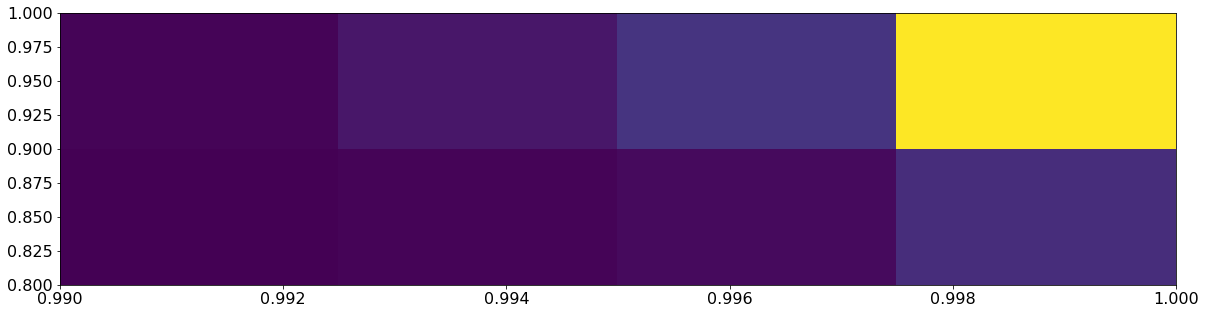

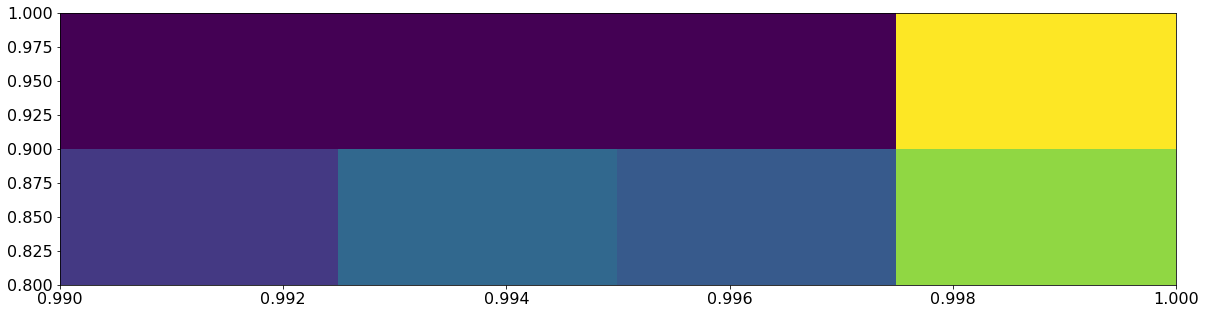

In [164]:
n_jobs=20
n_samples=1000
mu_bins = np.linspace(0, 50, 801)
ts_bins = np.linspace(0, 20, 201)
def main(n_jobs, n_samples):
    global mu_bins,ts_bins
    sig_exp, bkg_exp = np.sum(sig_df['weight']), np.sum(bkg_df['weight']) 
    bins_x, bins_y = get_default_binning()
   
    sig, bkg, xe, ye = build_histograms(
        sig_df, bkg_df, bins_x, bins_y,
        weight_col='weight') 
    
    plot_histogram(sig.T,xe,ye)
    plot_histogram(bkg.T,xe,ye)
    
    
    ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
    n_samples_per_mu = n_samples
    out_path ="/home/dup193/work/double_pulse/max_test/"
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    hists, ts_e = scan_neyman_plane(
        sig, bkg, bkg_exp,
        mu_bins, ts_bins, n_samples_per_mu,
        n_jobs=n_jobs, save=True,
        out_path=out_path)


if __name__ == '__main__':
    main(n_jobs,n_samples)

In [165]:
from glob import glob
import re
name_out = "/home/dup193/work/double_pulse/max_test/"
mat = []
hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
for file_name in glob(name_out+'*'):
    sp = re.split('_|\.|/',file_name)
    mu = float(sp[-3]+"."+sp[-2])
    i = np.where(mu_bins==mu)
    x = np.load(file_name, mmap_mode="r")['arr_0']
    hist, ts_e = np.histogram(x, bins=ts_bins)
    hist = hist / float(np.sum(hist))
    hists[i] = hist
#print(mat[0].shape)
#for i in mat:
#    print(i.shape)
#mat = np.stack(mat, axis=0)
#mat = mat.reshape(mat.shape[0],mat[0].shape[0])

In [166]:
print(hists)
#print(mat.shape)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.0020429  0.        ]
 [0.00101729 0.         0.         ... 0.         0.         0.00101729]
 [0.         0.         0.         ... 0.00103093 0.         0.00206186]]


/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Mean signal expectation $\\mu_t$')

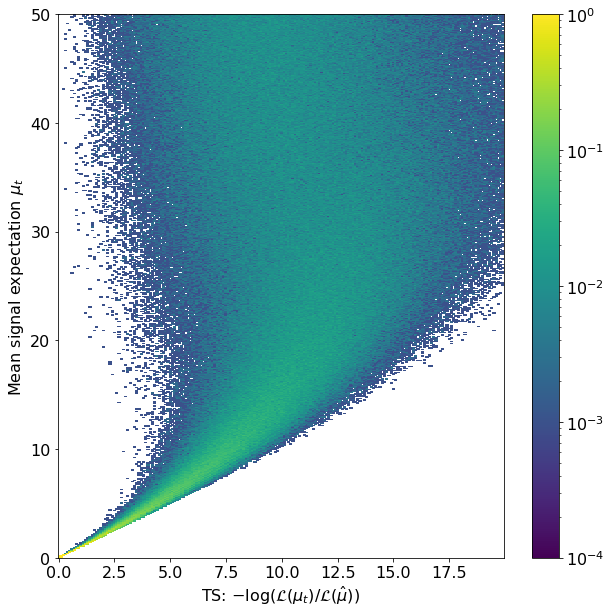

In [167]:
from matplotlib.colors import LogNorm
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])
fig = plt.figure(figsize=(10, 10),facecolor ='w')
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax = fig.add_subplot()
for i in range(len(mu_bins) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
plt.colorbar(im)
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')
# plt.savefig('plots/neyman_plane_hans.pdf', bbox_inches='tight')
#ax.imshow(hists,origin='lower',interpolation='none', extent=[0,20,0,20])